In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

In [73]:
def ViewPulses(filelocation, events, XRange, preTrgrDly):
    with h5py.File(filelocation, 'r') as f:
        for a in range(events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            plt.plot(pulse[preTrgrDly-100:])

def CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        for a in range(events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            pulse = pulse - baseline
            sum = np.sum(pulse[preTrgrDly-100:preTrgrDly+risetime])
            if sum > 0:
                spectra.append(sum)
        return(spectra)

def Gaussian(x, a, center, sigma, d):
    return a*np.exp(-(x-center)**2/(2*sigma**2))+d

def PeakInfo(hist, d, promF):
    peaklocations, _ = find_peaks(hist, distance=d, prominence=int(np.amax(hist))/promF)
    widths = peak_widths(hist, peaklocations, rel_height=0.5)
    Xranges = []
    coefficients = []
    numberofpeaks = 0
    FWHMs = []
    for i in range(len(peaklocations)):
        try:
            left = int(peaklocations[i]-widths[0][i])
            right = int(peaklocations[i]+widths[0][i])
            x = np.linspace(left, right, right-left)
            popt, pcov = curve_fit(Gaussian, x, hist[left:right], [hist[peaklocations[i]], peaklocations[i], widths[0][i], 0])
            popt[2] = np.abs(popt[2])
            Xranges.append(x)
            coefficients.append(popt)
            numberofpeaks += 1
            FWHMs.append(widths[0][i])
        except:
            pass
    return Xranges, coefficients, numberofpeaks, FWHMs


Specifying that counts start 100 before trigger (preTrgrDly-100)

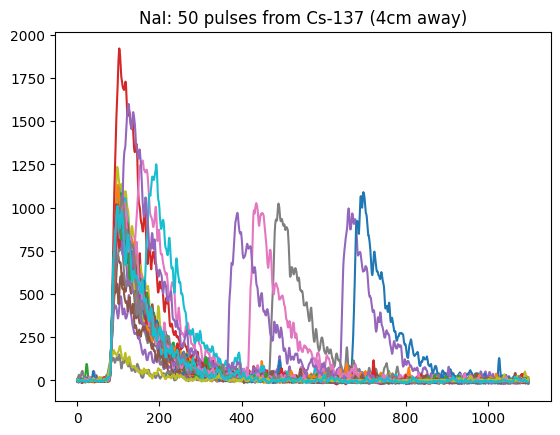

In [74]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 50
XRange = 5000
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (4cm away)')
plt.show()

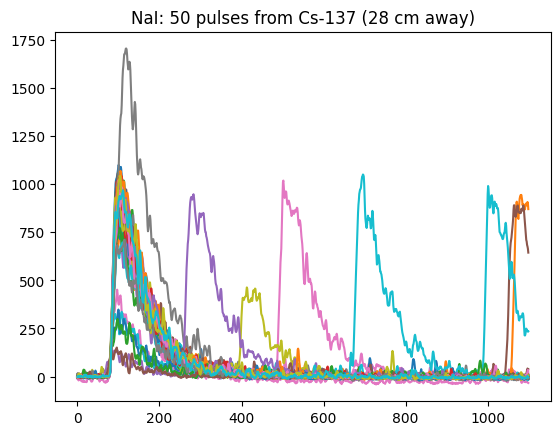

In [75]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
events = 50
XRange = 5000
preTrgrDly = 1000
ViewPulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Cs-137 (28 cm away)')
plt.show()

The initial pulses generally decay by about 400 counts in (1.6 microseconds), so I will use that as the initial guess for rise time. Don't see much of a difference in pile-up rate between 4 and 28 cm away however. Noting that since the pulse heights seem to average around 1000, integrating over 400 counts would give pulses that are almost all under 400*1000 = 400000. So I will set the histogram range to 0, 400000

Centroid is at: 215.98902934010684
FWHM is: 16.32088420892767
% Resolution = 7.556348699186944


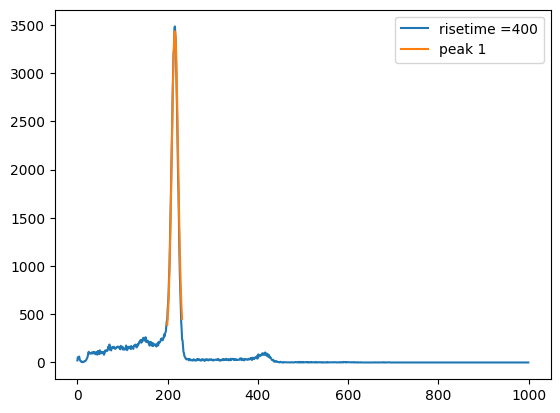

In [76]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 1000, range = (0, 400000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Seems like the range can be decreased to half of before.

Centroid is at: 431.9712503724685
FWHM is: 31.96982701133313
% Resolution = 7.400915450684982


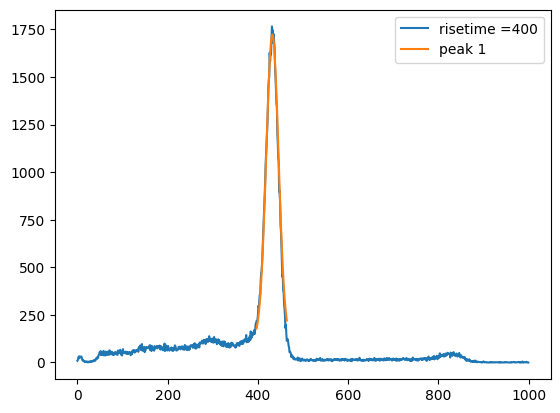

In [77]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Centroid is at: 432.80575296579553
FWHM is: 32.64876562582622
% Resolution = 7.543514706563164


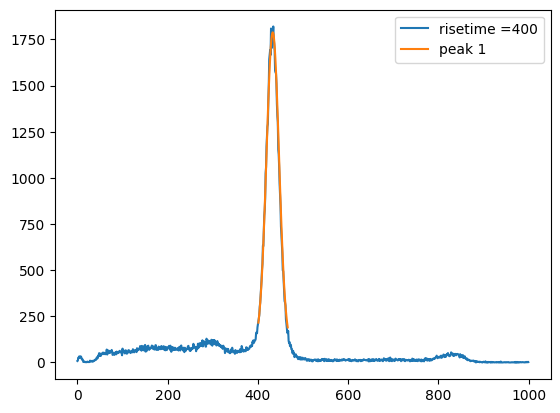

In [78]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 400

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Seems like the resolution for the Cs-137 662 keV gamma peak doesn't change drastically between having the source 4 cm away from the detector, and 28 cm away. Going to calculate the resolution for all distances we took data for, with integration periods between 100 and 900 counts

In [79]:
filelocations = [ 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_4cm_30.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_8cm_30.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_12cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_16cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_20cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_24cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_28cm_30.h5",
    ]

filenames = []
data = []
for a in filelocations:
    row = []
    filelocation = a
    filenames.append(os.path.split(a)[1])
    events = 200000
    XRange = 2000
    preTrgrDly = 1000
    peakdistance = 10
    prominencefactor = 2
    for b in range(9):
        resolutions = []
        risetime = 100*(b+1)
        spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
        hist, bins = np.histogram(spectra, bins = 5000)
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=filenames, columns=100*(np.array(range(9))+1))
df.style.background_gradient(axis=None)



,100,200,300,400,500,600,700,800,900
0,7.803257,7.698982,7.522434,7.425959,7.634365,7.666962,7.767608,8.056106,8.119311
1,7.765219,7.602573,7.613617,7.555983,7.629837,7.705679,7.801389,7.843015,8.038694
2,7.621651,7.398881,7.490818,7.388366,7.642522,7.673092,7.776049,7.810864,7.890600
3,7.677144,7.551038,7.427258,7.620844,7.574700,7.679692,7.723936,7.965858,8.026501
4,7.685662,7.435324,7.424617,7.440292,7.509754,7.569411,7.647269,7.734470,7.870882
5,7.800246,7.624407,7.610909,7.601923,7.585377,7.634901,7.747916,7.779447,7.948690
6,7.838112,7.568394,7.521695,7.534776,7.666505,7.661017,7.715815,7.804641,7.899613


This heatmap of the resolutions of the Cs-137 662 keV peak show that generally, optimal resolution results from integrating the pulse over 400 counts, starting from 100 counts before the trigger. One can see that rise times that are especially long (between 700 and 900 counts) impair resolution the most for the data taken with the source 4 cm away.

For 200000 events per, this process took 51 minutes.

Next, going to take a look at the resolution of some of the peaks from other sources.

Centroid is at: 311.9846220814525
FWHM is: 18.610515956551886
% Resolution = 5.9652029745533675
Centroid is at: 347.6379199493488
FWHM is: 18.431024353916285
% Resolution = 5.3017876636132515


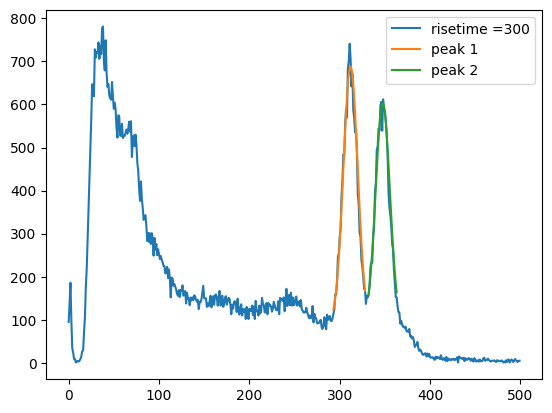

In [80]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Co60_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 2

risetime = 300

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 500, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Centroid is at: 40.63075036283934
FWHM is: 5.391553037555902
% Resolution = 13.269636886861402
Centroid is at: 105.27799460518077
FWHM is: 11.243672484051013
% Resolution = 10.679983529528315


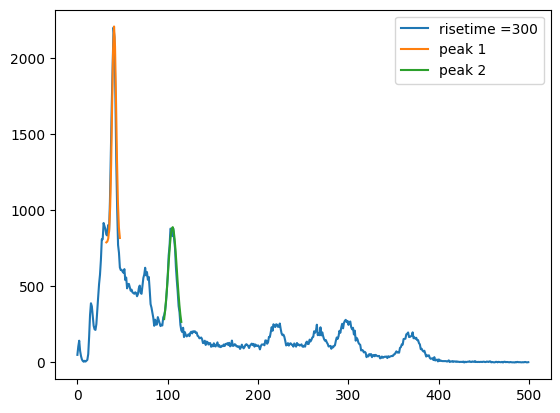

In [81]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Eu152_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 8

risetime = 300

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 500, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Centroid is at: 57.29503164665799
FWHM is: 222.58708268583305
% Resolution = 388.49281742008867
Centroid is at: 151.00802606312655
FWHM is: 13.568452951433425
% Resolution = 8.985252840641294
Centroid is at: 338.24446868010756
FWHM is: 19.306271403813806
% Resolution = 5.70778628816916


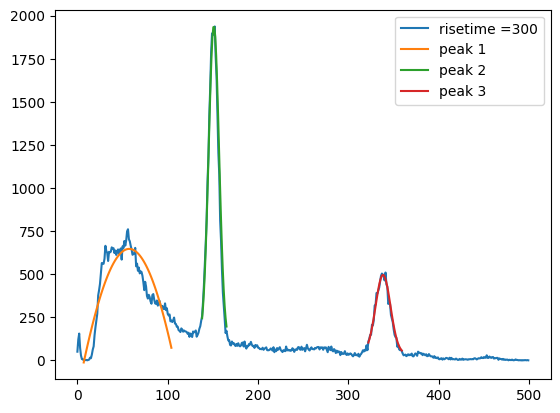

In [82]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Na22_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 5

risetime = 300

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 500, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

Centroid is at: 27.981006915910804
FWHM is: 4.765864662853276
% Resolution = 17.032498784535406
Centroid is at: 108.25554273606024
FWHM is: 9.487574119394965
% Resolution = 8.76405390394355


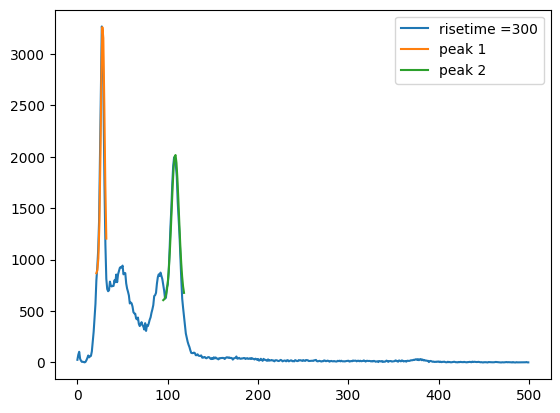

In [83]:
filelocation = r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Ba133_120s.h5"
events = 100000
XRange = 2000
preTrgrDly = 1000
peakdistance = 10
prominencefactor = 4

risetime = 300

spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)

hist, bins = np.histogram(spectra, bins = 500, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))

Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1]))
    print("FWHM is: " + str(2.35*coefficients[i][2]))
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1]))

plt.legend(loc='upper right')
plt.show()

In [85]:
filelocations = [ 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Ba133_120s.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Co60_120s.h5", 
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Cs137_16cm_30.h5",
    r"C:\Users\Operator\Documents\Devin\Code\Data\NaI_Eu152_120s.h5",
    ]

data = []
for a in filelocations:
    filelocation = a
    events = 200000
    XRange = 2000
    preTrgrDly = 1000
    peakdistance = 10
    prominencefactor = 2
    risetime = 300
    spectra = CreateSpectra(filelocation, events, XRange, preTrgrDly, risetime)
    hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
    Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
    for i in range(numberofpeaks):
        row = []
        row.append(os.path.split(a)[1])
        row.append(coefficients[i][1])
        row.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        data.append(row)

df = pd.DataFrame(data)
display(df)



,0,1,2
0,NaI_Ba133_120s.h5,55.682818,16.858115
1,NaI_Ba133_120s.h5,216.365418,9.358290
2,NaI_Co60_120s.h5,623.805404,5.701021
3,NaI_Co60_120s.h5,695.601950,5.149844
4,NaI_Cs137_16cm_30.h5,427.975068,7.427258
5,NaI_Eu152_120s.h5,81.177992,13.514123
